In [3]:
#dataset
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

# Trash Classification


In this project, I aim to classify trash images into six distinct categories using a Convolutional Neural Network (CNN). The model is trained on a dataset of labeled trash images, and its performance is tracked and evaluated using the Weights & Biases (wandb) experiment tracking tool.

CNNs are highly effective for image classification tasks due to their ability to automatically learn spatial hierarchies and patterns within images. The use of data augmentation and dropout ensures the model generalizes well to unseen data.

Pros:


*  The CNN architecture progressively captures features at multiple levels of abstraction, resulting in effective feature learning.
*   Data augmentation helps to artificially expand the dataset and improve

*   The model training and validation process is carefully monitored using wandb, enabling real-time insights and hyperparameter tuning.


Cons:

*   The sole reliance on accuracy as a metric might not capture nuances such as class imbalances or misclassification trends.
*   Training is computationally intensive due to the complex architecture and data augmentation techniques.



### Import Library

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from datasets import load_dataset
from PIL import Image
from collections import Counter
import random
import seaborn as sns
import wandb


## Data Preperation

In [5]:
dataset = load_dataset("garythung/trashnet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [6]:
# Define the base directory for saving organized image data
base_dir = './trash_data'
os.makedirs(base_dir, exist_ok=True) # Ensure the base directory exists (create it if it doesn't)
# Retrieve label names from the dataset
label_name = dataset['train'].features['label'].names
# Create subdirectories for each label in the base directory
for label in label_name:
  os.makedirs(os.path.join(base_dir, label), exist_ok=True)

#Save each image according to its label
for i,example in enumerate(dataset['train']):
  image = example['image']
  label = example['label']
  image.save(os.path.join(base_dir, label_name[label], f'{i}.jpg'))# Save the image in the folder corresponding to its label, with a unique filename


### Augmentation and Splitting

In [7]:
# Initialize an ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
                    rescale=1./255,              # Normalize pixel values to the range [0, 1]
                    rotation_range=20,           # Randomly rotate images by up to 20 degrees
                    horizontal_flip=True,        # Allow random horizontal flipping of images
                    shear_range=0.2,             # Apply random shearing transformations
                    zoom_range=0.2,              # Randomly zoom in/out on images
                    fill_mode='nearest',         # Fill in missing pixels after transformations
                    validation_split=0.3         # Reserve 30% of data for validation
                    )

# Initialize a separate ImageDataGenerator for validation data (no augmentation)
test_datagen = ImageDataGenerator(
                    rescale=1./255,              # Normalize pixel values to the range [0, 1]
                    validation_split=0.3         # Match the validation split
                    )


In [8]:
# Create a training data generator
train_generator = train_datagen.flow_from_directory(
        base_dir,                    # Directory containing the organized images
        target_size=(150, 150),      # Resize all images to 150x150 pixels
        batch_size=32,               # Process images in batches of 32
        class_mode='categorical',    # For multi-class classification
        subset='training'            # Use the training subset
        )

# Create a validation data generator
validation_generator = test_datagen.flow_from_directory(
        base_dir,                    # Directory containing the organized images
        target_size=(150, 150),      # Resize all images to 150x150 pixels
        batch_size=32,               # Process images in batches of 32
        class_mode='categorical',    # For multi-class classification
        subset='validation'          # Use the validation subset
        )

Found 3540 images belonging to 6 classes.
Found 1514 images belonging to 6 classes.


## Exploratory Image Analysis

In [9]:
# Displays the label name along with its index number.
label_names = dataset['train'].features['label'].names

print("Label List:")
for idx, label_name in enumerate(label_names):
    print(f"{idx} = {label_name}")


Label List:
0 = cardboard
1 = glass
2 = metal
3 = paper
4 = plastic
5 = trash


In [10]:
# Calculate and display the number of samples per class
label_counts = Counter(dataset['train']['label'])
print("Number of images per class:")
for label, count in label_counts.items():
    print(f"{label_names[label]}: {count} images")


Number of images per class:
cardboard: 806 images
glass: 1002 images
metal: 820 images
paper: 1188 images
plastic: 964 images
trash: 274 images


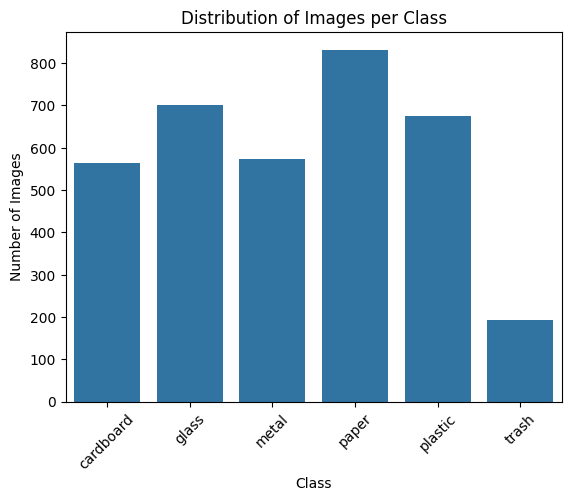

In [11]:
# Visualize the class distribution in the training data
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

sns.countplot(x=class_counts)
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.title('Distribution of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


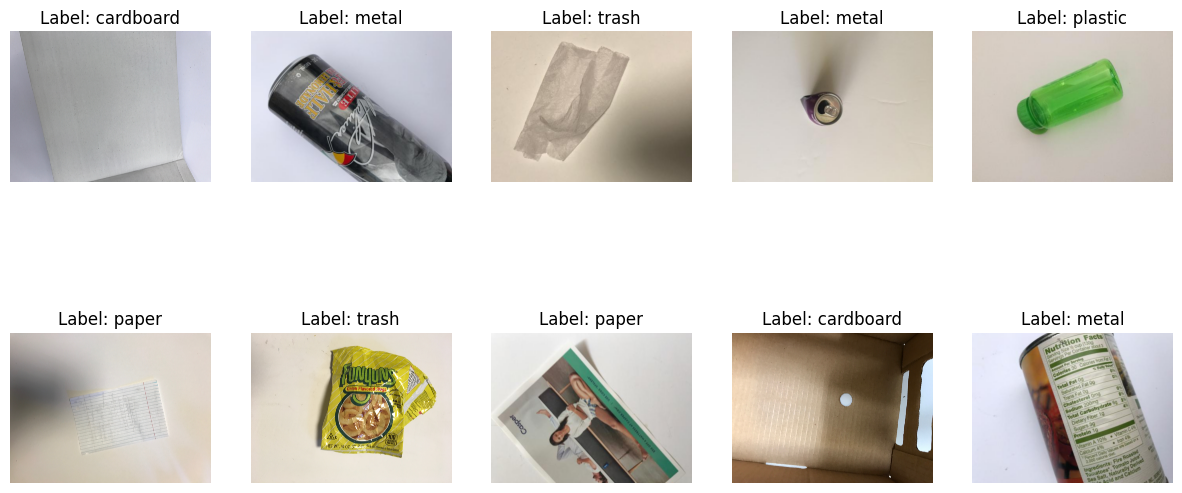

In [12]:
def show_random_images(dataset, num_samples=10):
    random_indices = random.sample(range(len(dataset['train'])), num_samples)

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        sample = dataset['train'][idx]
        image = sample['image']
        label = sample['label']

        plt.subplot(4, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label_names[label]}")
        plt.axis("off")
    plt.show()

# Display 10 random samples
show_random_images(dataset)


## Model Training and Evaluation Analysis

In [14]:
# Login to Weights & Biases (wandb) for experiment tracking
wandb.login()

# Initialize a new wandb project and set configuration parameters
wandb.init(
    project="trash_classification",  # Project name
    config={
        "config.concept": "cnn",      # Model concept: Convolutional Neural Network
        "dropout": 0.25,             # Dropout rate to reduce overfitting
        "loss": "categorical_crossentropy",  # Loss function for multi-class classification
        "metric": "accuracy",        # Metric to evaluate the model
        "epoch": 30,                 # Number of epochs for training
        "batch_size": 64             # Batch size for training
    }
)
config = wandb.config  # Access configuration parameters


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dk17 (dk178) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(config.dropout),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(config.dropout),#dropout layer untuk mengurangi overfitting
    tf.keras.layers.Dense(6, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    12,846,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,240,646 (50.51 MB)

 Trainable params: 13,240,646 (50.51 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001),
              loss= config.loss,
              metrics=[config.metric])

In [18]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Log training and validation metrics at the end of each epoch
        wandb.log({
            'epoch': epoch,
            'loss': logs['loss'],
            'accuracy': logs['accuracy'],
            'val_loss': logs['val_loss'],
            'val_accuracy': logs['val_accuracy']
        })

In [19]:
model.fit(
      train_generator,
      epochs = config.epoch,
      batch_size=config.batch_size,
      validation_data=validation_generator,
      verbose=1,
      callbacks= [WandbCallback(),tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.2351 - loss: 1.8713 - val_accuracy: 0.3388 - val_loss: 1.5582
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.3796 - loss: 1.4900 - val_accuracy: 0.4729 - val_loss: 1.3467
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.4707 - loss: 1.3271 - val_accuracy: 0.4630 - val_loss: 1.3392
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.5184 - loss: 1.2287 - val_accuracy: 0.4339 - val_loss: 1.4477
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.5616 - loss: 1.1336 - val_accuracy: 0.5892 - val_loss: 1.1615
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.5715 - loss: 1.0991 - val_accuracy: 0.5859 - val_loss: 1.0636
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6338 - loss: 0.9407 - val_accuracy: 0.6242 - val_loss: 1.0253
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.6632 - loss: 0.9122 - val_accu

In [20]:
loss, accuracy = model.evaluate(validation_generator, verbose=2)
print('Accuracy:', accuracy , 'Loss:', loss)


48/48 - 81s - 2s/step - accuracy: 0.6572 - loss: 0.9746
Accuracy: 0.6571994423866272 Loss: 0.9746206402778625


In [21]:
wandb.finish()

accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▄▃▆▆▇███
val_loss,█▆▆▇▄▃▂▁▁▂
accuracy,0.69831
epoch,9
loss,0.8126
val_accuracy,0.6572
val_loss,0.97462


Tracking with Wandb
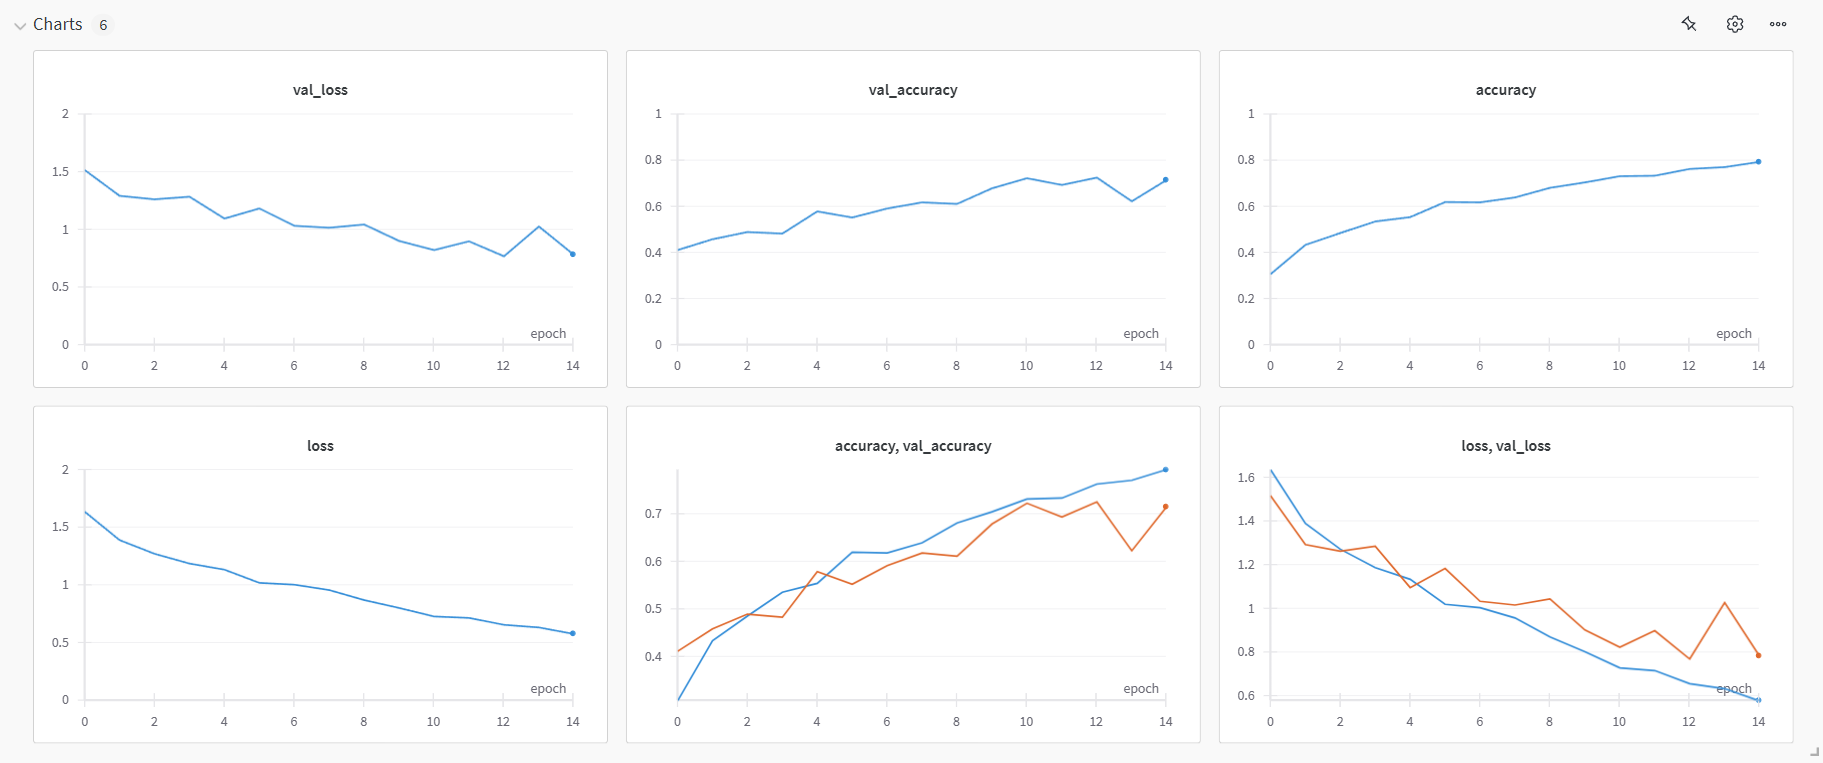

### Additional insight


**Model Bias:**



*   Class Imbalance:
If certain trash categories are underrepresented, the model may be biased towards classes with more samples. This can lead to higher false negatives or false positives for minority classes.
*   Augmentation introduces diversity but could also introduce bias. For instance, overly aggressive transformations might make images unrecognizable, reducing model performance on untransformed real-world data.


**Dataset issues**

*  The dataset might not capture all real-world variations in trash images, such as different lighting conditions, complex backgrounds, or occlusions. This can limit the generalizability of the model.



*   Some categories (e.g., "plastic" vs. "metal") might have visual similarities, leading to higher confusion between these classes.
Solution: Use confusion matrices to identify misclassifications and refine the model or dataset as needed.

